This code is used to process the data set given in the question,which has been processed by us.

Epoch 10/250, Loss: 0.6934
Epoch 20/250, Loss: 0.6861
Epoch 30/250, Loss: 0.6793
Epoch 40/250, Loss: 0.6707
Epoch 50/250, Loss: 0.6588
Epoch 60/250, Loss: 0.6428
Epoch 70/250, Loss: 0.6220
Epoch 80/250, Loss: 0.5963
Epoch 90/250, Loss: 0.5669
Epoch 100/250, Loss: 0.5355
Epoch 110/250, Loss: 0.5046
Epoch 120/250, Loss: 0.4760
Epoch 130/250, Loss: 0.4510
Epoch 140/250, Loss: 0.4298
Epoch 150/250, Loss: 0.4124
Epoch 160/250, Loss: 0.3984
Epoch 170/250, Loss: 0.3872
Epoch 180/250, Loss: 0.3782
Epoch 190/250, Loss: 0.3708
Epoch 200/250, Loss: 0.3647
Epoch 210/250, Loss: 0.3595
Epoch 220/250, Loss: 0.3551
Epoch 230/250, Loss: 0.3512
Epoch 240/250, Loss: 0.3478
Epoch 250/250, Loss: 0.3448


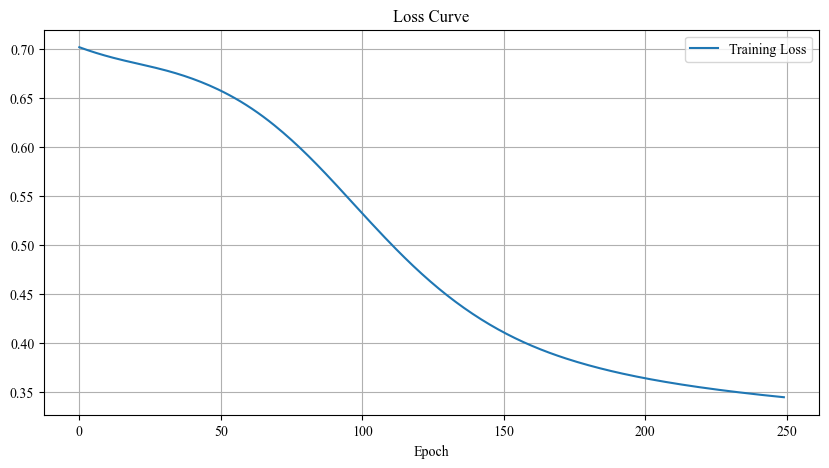

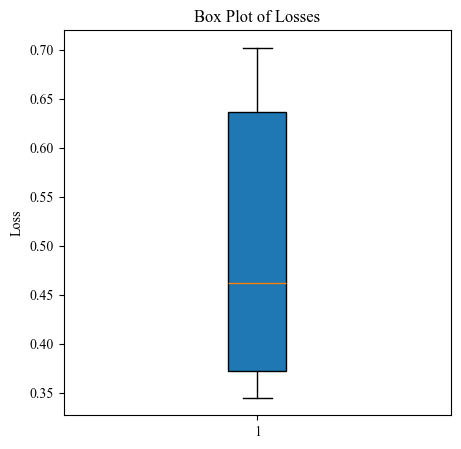

Accuracy: 0.8042
Model parameters saved to /Users/curryyang/code/2024_MCM_C_UESTC/modle/set_predictor_model.pth
SetPredictor(
  (fc1): Linear(in_features=14, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=14, bias=True)
  (fc3): Linear(in_features=14, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
[[-0.24809395  0.3962314  -0.11580958 -0.36692423  0.10853903 -0.1190239
   0.34883273 -0.34274697  0.37895286 -0.11545953  0.07858182 -0.27561632
  -0.44807327 -0.10794318]
 [-0.4444386  -0.35955784 -0.45956278  0.26654166  0.2557945  -0.00610867
   0.3389046  -0.30052346  0.26824653  0.14923613 -0.46305478  0.0833535
   0.18630189 -0.15880775]
 [-0.1426256   0.40032622  0.09161475  0.14692955 -0.3138743  -0.07473401
   0.30974734 -0.21539466  0.28314874  0.01634278  0.1599394   0.10177369
  -0.10726034 -0.28680512]
 [ 0.18485847  0.02765549  0.36966413  0.06419653 -0.18897118  0.15742938
  -0.4053254   0.3214668  -0.50882834 -0.00743591 -0.22343397 -0.28513664

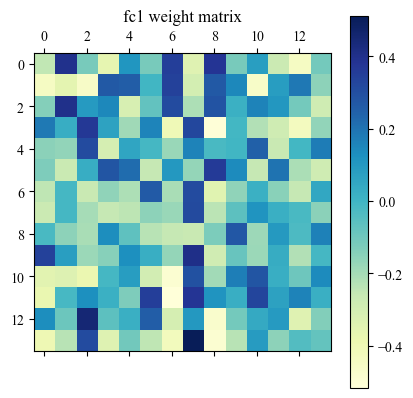

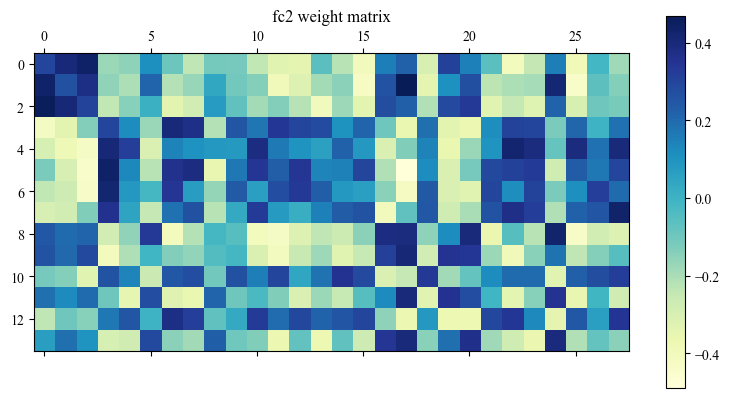

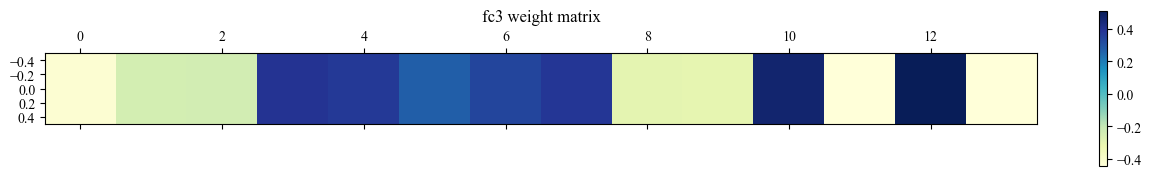

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('/Users/curryyang/code/2024_MCM_C_UESTC/processed_datasets/male_processed.csv')

# 选择特征和预处理
features = data[['p1_ace', 'p2_ace', 'p1_break_pt_won', 'p2_break_pt_won', 'p1_double_fault', 'p2_double_fault', 'p1_unf_err', 'p2_unf_err','server','serve_no','p1_net_pt','p2_net_pt','p1_distance_run','p2_distance_run']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 构造每个set的胜者标签（简化逻辑）
# 假设set的胜者是在该set中得分更多的玩家
# 注意：这里的逻辑可能需要根据实际数据和规则进行调整
set_winner = (data['point_victor'] == 1).astype(int)

# 划分数据集（这里我们简化，直接使用行号进行划分）
X_train, X_test = features_scaled[:6952], features_scaled[6952:]
y_train, y_test = set_winner[:6952], set_winner[6952:]

# 将NumPy数组转换为Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# 神经网络定义
class SetPredictor(nn.Module):
    def __init__(self):
        super(SetPredictor, self).__init__()
        self.fc1 = nn.Linear(14, 28)
        self.fc2 = nn.Linear(28, 14)
        self.fc3 = nn.Linear(14, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# 实例化模型、定义损失函数和优化器
model = SetPredictor()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 250
epoch_loss = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    epoch_loss.append(loss.item())


    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10, 5))
plt.plot(epoch_loss, label='Training Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 5))
plt.boxplot(epoch_loss, vert=True, patch_artist=True)
plt.title('Box Plot of Losses')
plt.ylabel('Loss')
plt.show()

# 简单评估模型
model.eval()
with torch.no_grad():
    outputs0 = model(X_train_tensor).squeeze()
    outputs = model(X_test_tensor).squeeze()
    predictions = (outputs >= 0.5).float()
    accuracy = (predictions == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy:.4f}')
features_array = np.append(X_train_tensor.numpy(), X_test_tensor.numpy(), axis=0)
predictions_array = np.append(outputs0.numpy(), outputs.numpy(), axis=0)
export_data = np.hstack((features_array, predictions_array.reshape(-1, 1)))
features_original = scaler.inverse_transform(features_array)
export_df = pd.DataFrame(features_original, columns=['p1_ace', 'p2_ace', 'p1_break_pt_won', 'p2_break_pt_won', 'p1_double_fault', 'p2_double_fault', 'p1_unf_err', 'p2_unf_err','sever','serve_no','p1_net_pt','p2_net_pt','p1_distance_run','p2_distance_run'])
export_df['Predicted_Value'] = predictions_array
export_df['time'] = data['elapsed_time']

# 导出DataFrame为CSV文件
export_df.to_csv('/Users/curryyang/code/2024_MCM_C_UESTC/exported_datasets/exported.csv', index=False)


# 模型保存路径
model_path = '/Users/curryyang/code/2024_MCM_C_UESTC/modle/set_predictor_model.pth'

# 保存模型的状态字典
torch.save(model.state_dict(), model_path)

print(f'Model parameters saved to {model_path}')

import torch
import torchvision.models as models

# 加载权重
model.load_state_dict(torch.load('/Users/curryyang/code/2024_MCM_C_UESTC/modle/set_predictor_model.pth'))

model.eval()

print(model)

import matplotlib.pyplot as plt

weights1 = model.fc1.weight.data.numpy()
weights2 = model.fc2.weight.data.numpy()
weights3 = model.fc3.weight.data.numpy()

# 选择权重的一个子集进行可视化
weights_subset1 = weights1[:14]
weights_subset2 = weights2[:28]
weights_subset3 = weights3[:14]
print(weights_subset1)
print(weights_subset2)
print(weights_subset3)
plt.matshow(weights_subset1, cmap='YlGnBu')  # 选择一个颜色映射
plt.colorbar() # 显示颜色条
plt.title('fc1 weight matrix')
plt.matshow(weights_subset2, cmap='YlGnBu') 
plt.colorbar() 
plt.title('fc2 weight matrix')
plt.matshow(weights_subset3, cmap='YlGnBu') 
plt.colorbar() 
plt.title('fc3 weight matrix')

# 显示图像
plt.show()



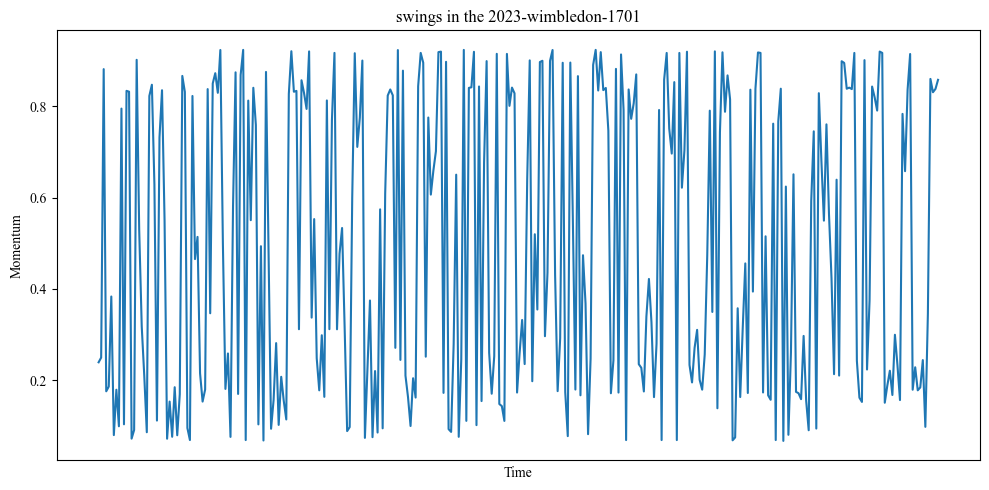

In [18]:
dataflow = pd.read_csv('/Users/curryyang/code/2024_MCM_C_UESTC/exported_datasets/exported.csv')
x = dataflow['time'].iloc[6952:7286]
y = dataflow['Predicted_Value'].iloc[6952:7286]
plt.figure(figsize=(10, 5))
plt.plot(x, y)
ax = plt.gca()

# 隐藏x轴的刻度
ax.set_xticks([])

# 隐藏x轴的刻度标签（如果需要）
ax.set_xticklabels([])
plt.xlabel('Time')
plt.ylabel('Momentum')
plt.title('swings in the 2023-wimbledon-1701')
plt.tight_layout() 
plt.show()